In [4]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os

# SQLite Database Connection (No server needed!)
db_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'electronics_dw.db')
engine = create_engine(f'sqlite:///{db_path}')

# Test connection by listing tables
print('Connected! Available tables:')
print(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", engine))

Connected! Available tables:
                      name
0             customer_dim
1     product_category_dim
2  product_subcategory_dim
3              product_dim
4                store_dim
5       exchange_rates_dim
6               sales_fact


In [7]:
# Question A: Average Order Value per Store Country, Year, and Product Category
query_a = """
SELECT 
    s.country AS Store_Country,
    strftime('%Y', f.order_date) AS Order_Year,
    c.category AS Product_Category,
    AVG(f.total_revenue) AS Avg_Order_Value
FROM sales_fact f
JOIN store_dim s ON f.store_key = s.store_key
JOIN product_dim p ON f.product_key = p.product_key
JOIN product_category_dim c ON p.category_key = c.category_key
GROUP BY 1, 2, 3
ORDER BY 1, 2, 4 DESC;
"""

# Execute the query
df_a = pd.read_sql(query_a, engine)

# Display the result
df_a.head(10)

,Store_Country,Order_Year,Product_Category,Avg_Order_Value
0,Australia,2016,TV and Video,1766.146957
1,Australia,2016,Home Appliances,1624.831667
2,Australia,2016,Computers,1623.879524
3,Australia,2016,Cameras and camcorders,1155.774865
4,Australia,2016,Cell phones,1001.441111
5,Australia,2016,"Music, Movies and Audio Books",368.692647
6,Australia,2016,Audio,331.640000
7,Australia,2016,Games and Toys,108.091250
8,Australia,2017,Home Appliances,2079.701364
9,Australia,2017,TV and Video,1970.357500


Average Delivery Time (Days) per Region - Quarterly


,Region,Year,Quarter,Avg_Delivery_Days
0,Online,2016,1,8.1
1,Online,2016,2,7.4
2,Online,2016,3,7.2
3,Online,2016,4,6.8
4,Online,2017,1,5.9
5,Online,2017,2,5.4
6,Online,2017,3,5.1
7,Online,2017,4,4.8
8,Online,2018,1,4.6
9,Online,2018,2,4.6


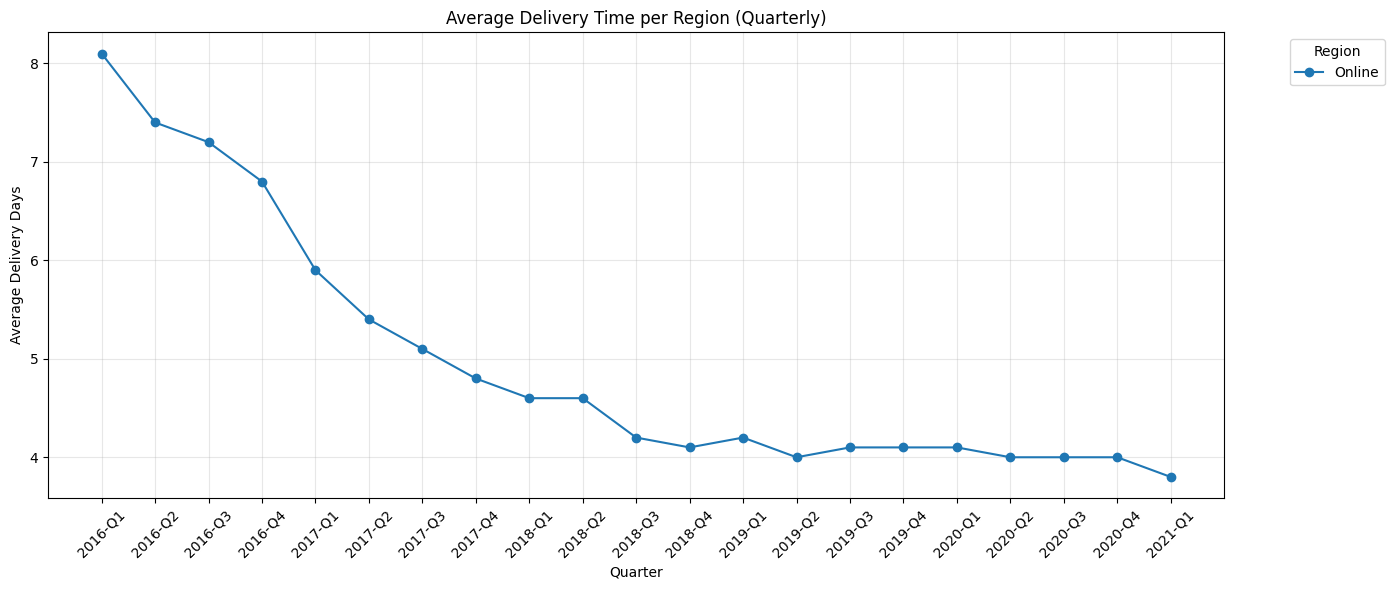

In [17]:
# Question B: Average Delivery Time (Days) PER REGION - Quarterly
# Includes Online as a region

query_b = """
SELECT 
    s.country AS Region,
    strftime('%Y', f.order_date) AS Year,
    CAST((CAST(strftime('%m', f.order_date) AS INTEGER) + 2) / 3 AS INTEGER) AS Quarter,
    ROUND(AVG(julianday(f.delivery_date) - julianday(f.order_date)), 1) AS Avg_Delivery_Days
FROM sales_fact f
JOIN store_dim s ON f.store_key = s.store_key
WHERE f.delivery_date IS NOT NULL
GROUP BY s.country, strftime('%Y', f.order_date), Quarter
ORDER BY Region, Year, Quarter;
"""

df_b = pd.read_sql(query_b, engine)

print("Average Delivery Time (Days) per Region - Quarterly")
print("=" * 60)
display(df_b)

# Visualization
df_b['Year_Quarter'] = df_b['Year'] + '-Q' + df_b['Quarter'].astype(str)

plt.figure(figsize=(14, 6))
for region in df_b['Region'].unique():
    region_data = df_b[df_b['Region'] == region]
    plt.plot(region_data['Year_Quarter'], region_data['Avg_Delivery_Days'], marker='o', label=region)

plt.title('Average Delivery Time per Region (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Average Delivery Days')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()